# **Importing Data**

In [5]:
import os
from PIL import Image, ImageFilter

women_dataset = 'D:/CUFE_Courses/3-Senior1/Spring2023/CMPN450_Pattern-Recognition-&-Neural-Networks/Project/Dataset_0-5/Women'
men_dataset = 'D:/CUFE_Courses/3-Senior1/Spring2023/CMPN450_Pattern-Recognition-&-Neural-Networks/Project/Dataset_0-5/men'

images_paths = []
# dataset_labels = []
classes_sizes=[]
corrupted=0
corrupted_imgs=[]
for i in range(6):
  women_folder_path = os.path.join(women_dataset, str(i))
  men_folder_path = os.path.join(men_dataset, str(i))
  # Get the file paths in the folders
  women_files = [os.path.join(women_folder_path, f) for f in os.listdir(women_folder_path) if os.path.isfile(os.path.join(women_folder_path, f))]
  men_files = [os.path.join(men_folder_path, f) for f in os.listdir(men_folder_path) if os.path.isfile(os.path.join(men_folder_path, f))]

  imgs = women_files + men_files
  for img in imgs:
    if not img.endswith(".JPG"):          # in case of desktop.ini file or any other file
        continue

    try:
        temp = Image.open(img)
    except (IOError, SyntaxError) as e:   # in case of corrupted images
        print('Bad file:', temp)
        corrupted+=1
        continue 
    path = img.split('/')
    images_paths.append(img)
    
    
  classes_sizes.append(len(imgs))    
print("Total number of images = ", len(images_paths))
print("Number of corrupted images or desktop.ini file = ", corrupted)
print("Number of images per class = ", classes_sizes)

Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1EB45AF28C0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1EB45AF28C0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1EB45AF28C0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1EB45AF28C0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1EB45B6BE50>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1EB45AF28C0>
Total number of images =  1821
Number of corrupted images or desktop.ini file =  6
Number of images per class =  [289, 302, 312, 320, 305, 311]


# **Image Pre-processing**

In [57]:
import numpy as np
import cv2 as cv

# Define the target size for the images
target_size = (200, 200)

def image_preprocess(img_path):
    # Load the image
    image = cv.imread(img_path)

    # Resize the image to the target size
    resized_img = cv.resize(image, target_size)

    # Convert the resized image to grayscale
    gray_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)

    # Normalize the pixel values to be between 0 and 1
    # normalized_img  = gray_img / 255.0
    normalized_img = (gray_img - np.min(gray_img)) * 255.0 / (np.max(gray_img) - np.min(gray_img))

    return resized_img, normalized_img    # return the original and the preprocessed images


Image shape after preprocessing =  (200, 200)


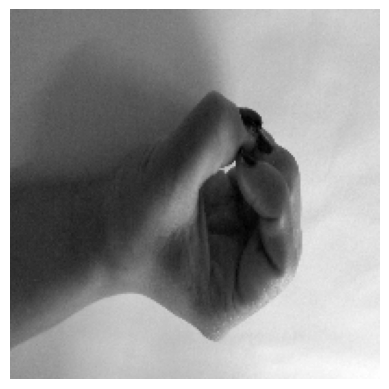

True

In [58]:
import matplotlib.pyplot as plt

resized, norm = image_preprocess(images_paths[0])
print("Image shape after preprocessing = ", norm.shape)

# Display the original and processed images
# cv.imshow('Original Image', norm)
plt.axis("off")
plt.imshow(norm, cmap='gray')
plt.show()
cv.imwrite("Preprocessed_Image.JPG", norm)

# **Image Segmentation**

In [76]:
def image_segmentation(img):
    # Apply Gaussian blur to remove noise (optional)
    img = cv.GaussianBlur(img, (5, 5), 0)

    # Apply Otsu's thresholding to get binary image
    # _, thresh = cv.threshold(img, 75, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    ret,thresh = cv.threshold(skinRegionHSV,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    return thresh

In [77]:
# Convert the normalized image to uint8
# uint8_img = cv.convertScaleAbs(norm, alpha=(255.0))
uint8_img = norm.astype(np.uint8)

binary_img = image_segmentation(resized)
print("Image shape after segmentation = ", binary_img.shape)
cv.imwrite("Binary_Image.JPG", binary_img)

Image shape after segmentation =  (200, 200)


True